In [25]:
import pandas as pd
import numpy as np

In [26]:
bkk_pm_filled = pd.read_csv("../../data/a1/bkk_pm_filled.csv", parse_dates=["date"])

bkk_pm_filled.drop(columns=["avg"], inplace=True)

In [27]:
bkk_pm_filled

,date,temperature_min,dew_point_avg,humidity_avg,wind_speed_max,pressure_max
0,2011-05-31,68.774194,74.629032,73.600000,14.161290,29.806452
1,2011-06-30,73.766667,74.066667,72.106667,17.966667,29.756667
2,2011-07-31,70.483871,73.803226,74.603226,15.354839,29.764516
3,2011-08-31,75.580645,73.783871,74.232258,14.935484,29.787097
4,2011-09-30,67.400000,73.633333,75.316667,15.233333,29.786667
...,...,...,...,...,...,...
159,2024-08-31,77.193548,75.390323,73.041935,14.967742,29.816129
160,2024-09-30,79.200000,75.580000,75.266667,15.200000,29.783333
161,2024-10-31,78.967742,75.712903,76.603226,13.129032,29.864516
162,2024-11-30,78.233333,71.273333,66.146667,11.500000,29.890000


In [28]:
feature_list = [col for col in bkk_pm_filled.columns if col != 'date']

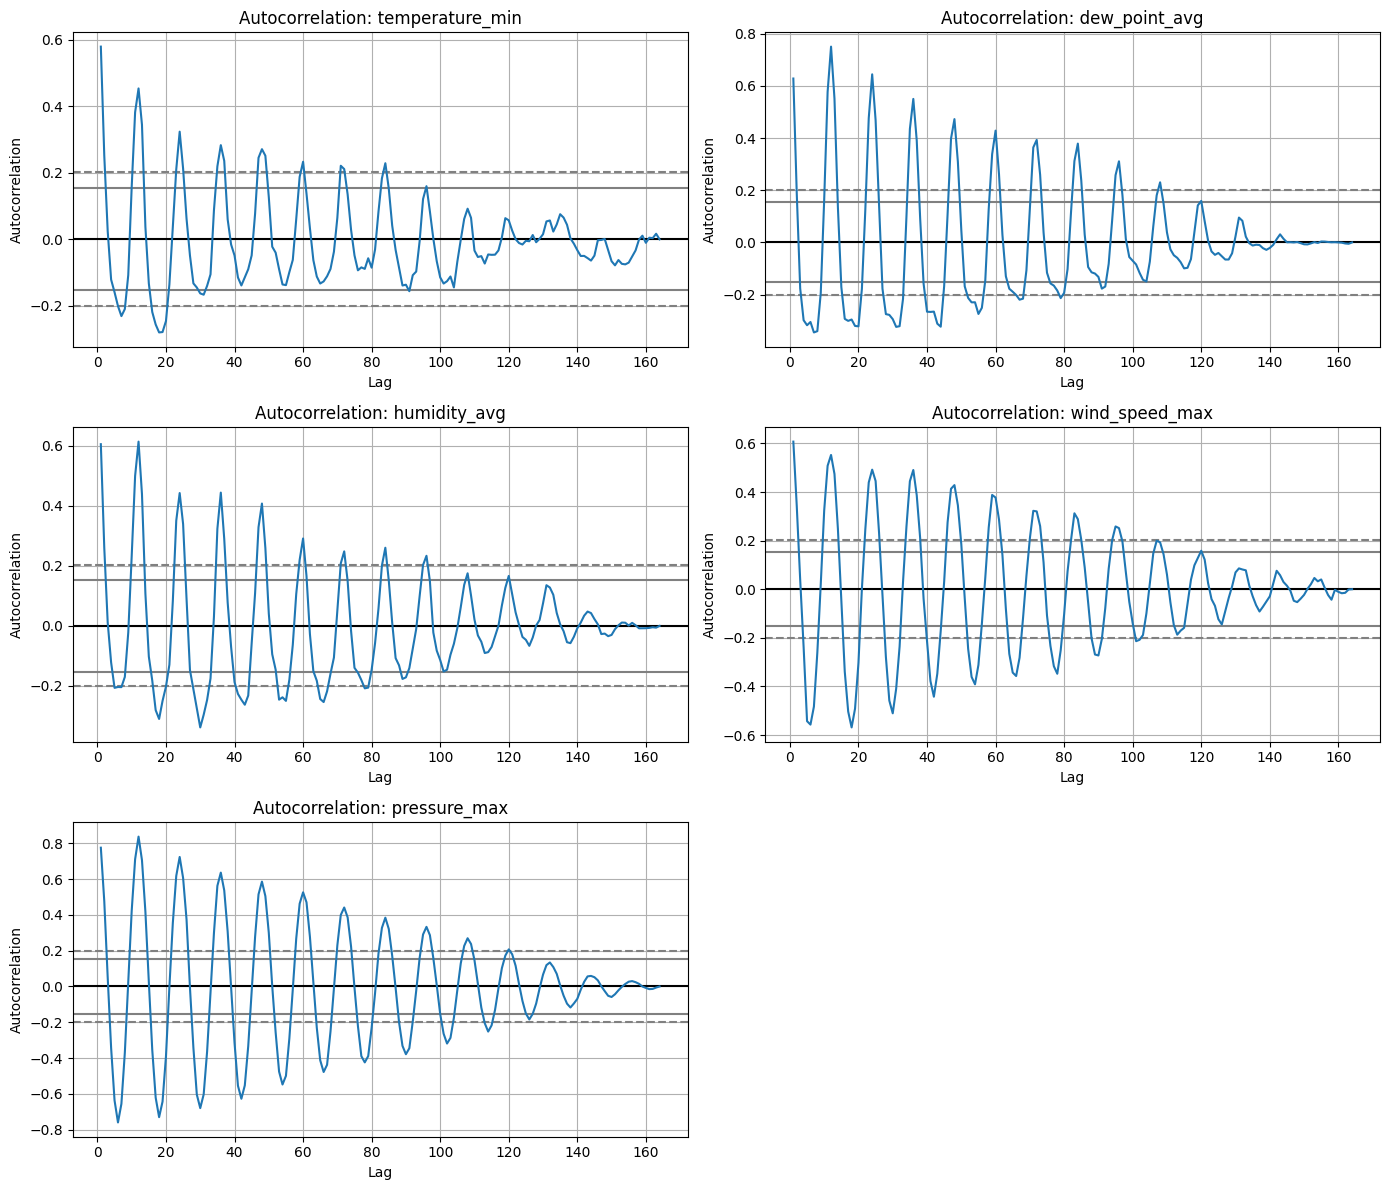

In [29]:
from pandas.plotting import autocorrelation_plot
import matplotlib.pyplot as plt

# Create subplots
fig, axes = plt.subplots(nrows=3, ncols=2, figsize=(14, 12))
axes = axes.flatten()

# Plot autocorrelation for each feature
for i, feature in enumerate(feature_list):
    autocorrelation_plot(bkk_pm_filled[feature].dropna(), ax=axes[i])
    axes[i].set_title(f'Autocorrelation: {feature}')

# Hide unused subplot if any
for j in range(len(feature_list), len(axes)):
    fig.delaxes(axes[j])

plt.tight_layout()
plt.show()

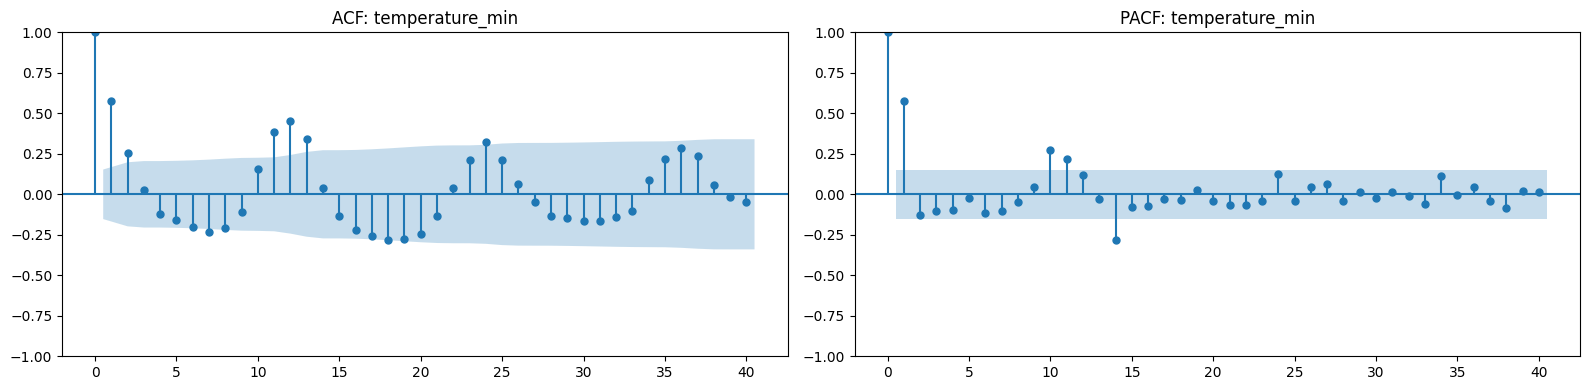

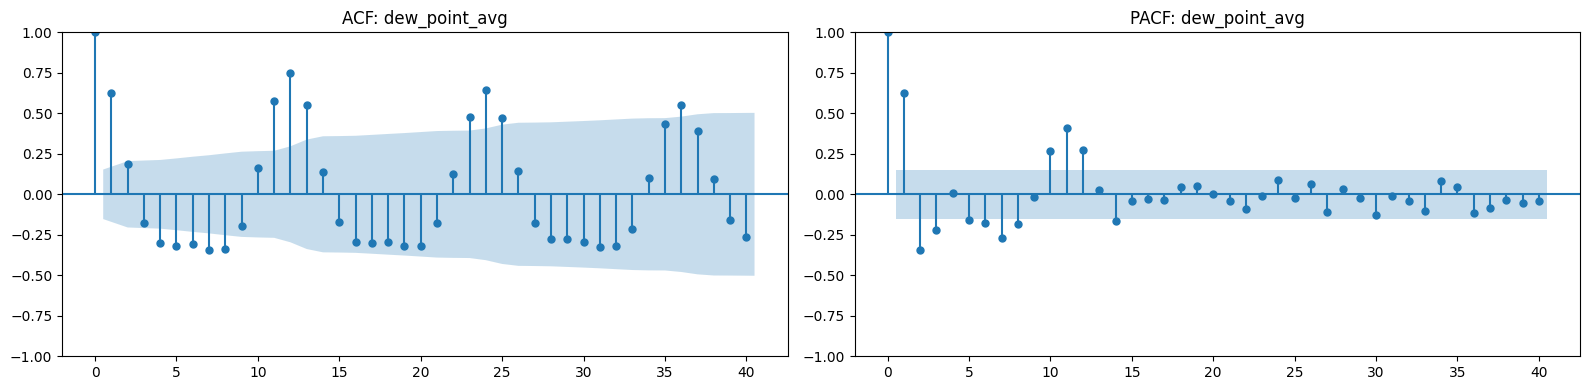

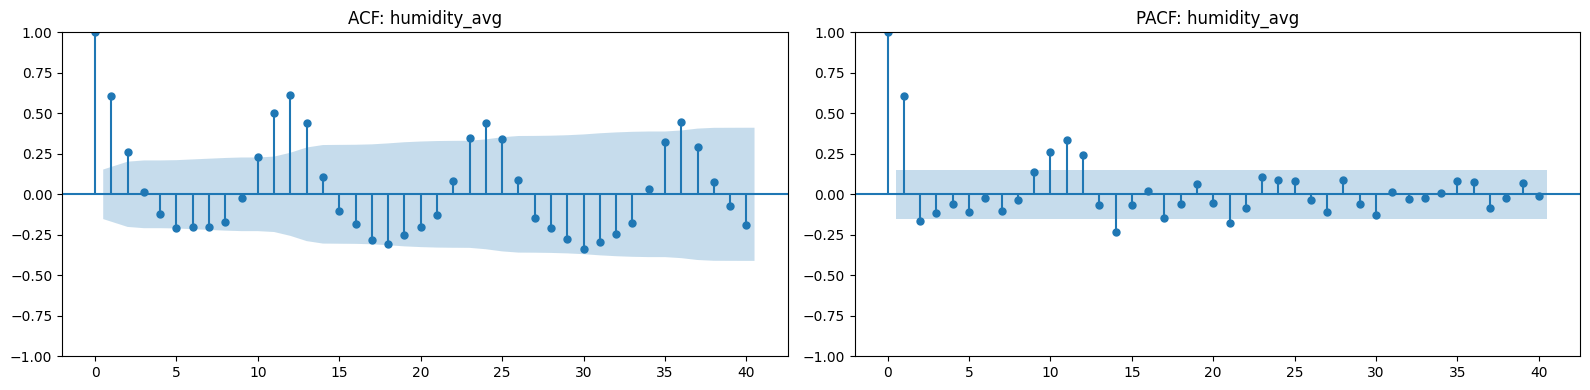

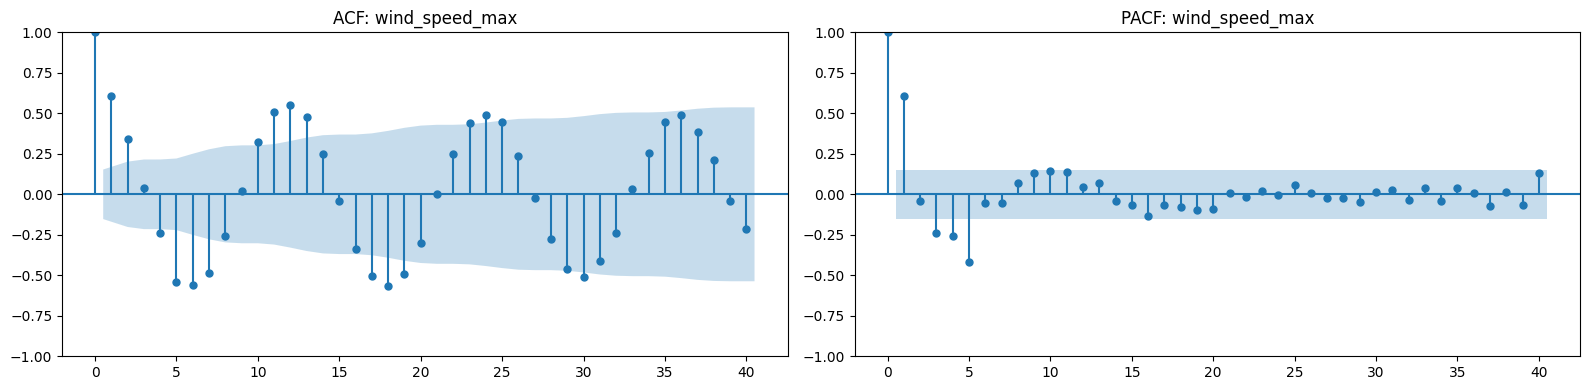

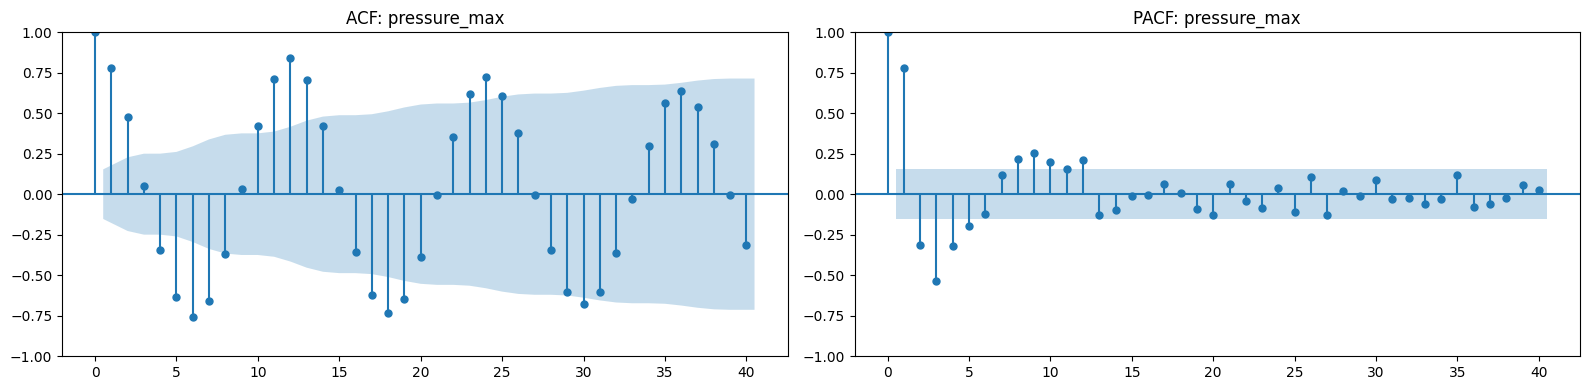

In [30]:
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
n_lags = 40

for feature in feature_list:
    fig, axes = plt.subplots(1, 2, figsize=(16, 4))

    # ACF plot
    plot_acf(bkk_pm_filled[feature].dropna(), ax=axes[0], lags=n_lags)
    axes[0].set_title(f'ACF: {feature}')

    # PACF plot
    plot_pacf(bkk_pm_filled[feature].dropna(), ax=axes[1], lags=n_lags, method='ywm')
    axes[1].set_title(f'PACF: {feature}')

    plt.tight_layout()
    plt.show()

In [31]:
from statsmodels.tsa.statespace.sarimax import SARIMAX
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score

In [32]:
def mean_absolute_percentage_error(y_true, y_pred):
    y_true, y_pred = np.array(y_true), np.array(y_pred)
    return np.mean(np.abs((y_true - y_pred) / y_true)) * 100

In [33]:
def check_stationarity(y):
    result = adfuller(y)
    print(f'ADF Statistic: {result[0]:.3f}')
    print(f'p-value: {result[1]:.3f}')
    print('Critical Values:')
    for key, value in result[4].items():
        print(f'   {key}: {value:.3f}')

    if result[1] < 0.05:
        print("Stationary: Yes")
        return True
    else:
        print("Stationary: No")
        return False 

In [34]:
from statsmodels.tsa.stattools import adfuller


In [35]:
forecast_steps = 12

In [36]:
def SARIMA(mode):
    global forecast_combined_df
    forecast_combined_df = pd.DataFrame()
    for feature in feature_list:
        y = bkk_pm_filled[feature].dropna()

        # Ensure datetime index
        if not isinstance(y.index, pd.DatetimeIndex):
            y.index = pd.to_datetime(bkk_pm_filled.loc[y.index, "date"])

        print(f"Stationarity check for {feature}:")
        is_stationary = check_stationarity(y)
        print("="*50)

        d = 0 if is_stationary else 1
        sarima_order = (1, d, 1)
        seasonal_order = (1, 1, 1, 12)

        if mode == 0:
            # Train-test split (last 12 months as test set)
            y_train = y[:-forecast_steps]
            y_test = y[-forecast_steps:]
        else:
            # Use all data for training to forecast future
            y_train = y
            y_test = None

        # Fit SARIMA model
        model = SARIMAX(y_train, order=sarima_order, seasonal_order=seasonal_order,
                        enforce_stationarity=False, enforce_invertibility=False)
        result = model.fit(disp=False)

        # Forecast
        forecast = result.get_forecast(steps=forecast_steps)
        forecast_mean = forecast.predicted_mean
        forecast_ci = forecast.conf_int()

        # Set forecast index
        start_date = y.index[-forecast_steps] + pd.offsets.MonthBegin(1) if mode == 0 else y.index[-1] + pd.offsets.MonthBegin(1)
        forecast_index = pd.date_range(start=start_date, periods=forecast_steps, freq='MS')
        forecast_mean.index = forecast_index
        forecast_ci.index = forecast_index

        if mode == 0:
            y_test.index = forecast_index

        # Store forecast
        forecast_combined_df[feature] = forecast_mean

        # Plot
        fig, ax = plt.subplots(figsize=(12, 5))
        y.plot(ax=ax, label='Observed', color='blue')
        forecast_mean.plot(ax=ax, label='Forecast', color='red', style='--')
        ax.fill_between(forecast_index, forecast_ci.iloc[:, 0], forecast_ci.iloc[:, 1], color='red', alpha=0.3, label='Confidence Interval')
        ax.set_title(f'SARIMA Forecast: {feature}')
        ax.legend()
        plt.grid(True)
        plt.tight_layout()
        plt.show()

        # Print forecasts
        print(f"Forecasted values for {feature}:")
        print(forecast_mean)

        # Print metrics if test available
        if mode == 0:
            mae = mean_absolute_error(y_test, forecast_mean)
            rmse = np.sqrt(mean_squared_error(y_test, forecast_mean))
            mape = mean_absolute_percentage_error(y_test, forecast_mean)
            r2 = r2_score(y_test, forecast_mean)

            print(f"Forecast Accuracy Metrics for {feature}:")
            print(f"MAE  : {mae:.3f}")
            print(f"RMSE : {rmse:.3f}")
            print(f"MAPE : {mape:.2f}%")
            print(f"R²   : {r2:.3f}")


Stationarity check for temperature_min:
ADF Statistic: -2.850
p-value: 0.051
Critical Values:
   1%: -3.475
   5%: -2.881
   10%: -2.577
Stationary: No


C:\Users\poyni\AppData\Roaming\Python\Python312\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency ME will be used.
  self._init_dates(dates, freq)
C:\Users\poyni\AppData\Roaming\Python\Python312\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency ME will be used.
  self._init_dates(dates, freq)


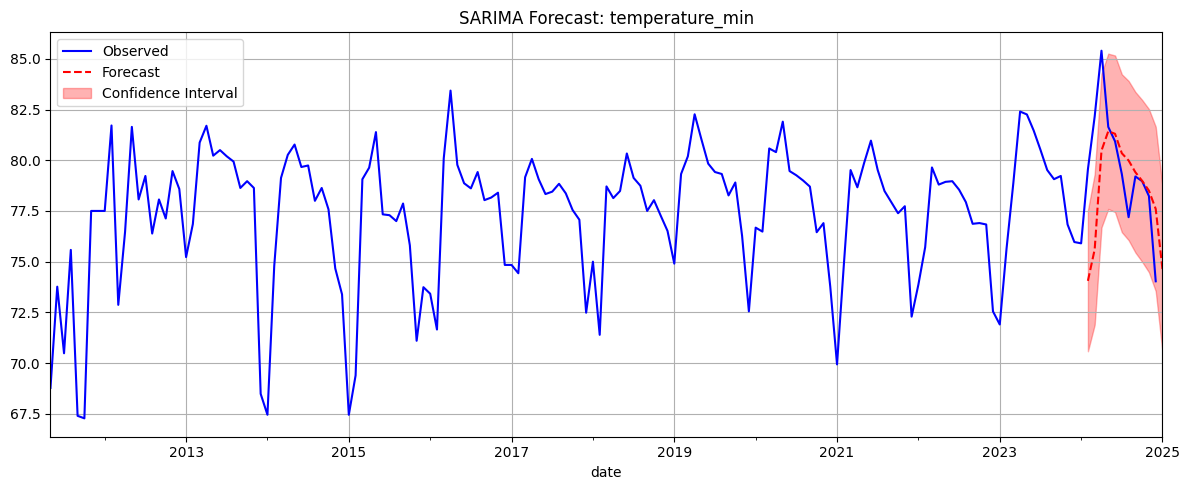

Forecasted values for temperature_min:
2024-02-01    74.055090
2024-03-01    75.607799
2024-04-01    80.473385
2024-05-01    81.428704
2024-06-01    81.304838
2024-07-01    80.345776
2024-08-01    79.987011
2024-09-01    79.408939
2024-10-01    78.983647
2024-11-01    78.499877
2024-12-01    77.599183
2025-01-01    74.617064
Freq: MS, Name: predicted_mean, dtype: float64
Forecast Accuracy Metrics for temperature_min:
MAE  : 1.430
RMSE : 1.924
MAPE : 1.78%
R²   : 0.549
Stationarity check for dew_point_avg:
ADF Statistic: -2.161
p-value: 0.221
Critical Values:
   1%: -3.475
   5%: -2.881
   10%: -2.577
Stationary: No


C:\Users\poyni\AppData\Roaming\Python\Python312\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency ME will be used.
  self._init_dates(dates, freq)
C:\Users\poyni\AppData\Roaming\Python\Python312\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency ME will be used.
  self._init_dates(dates, freq)


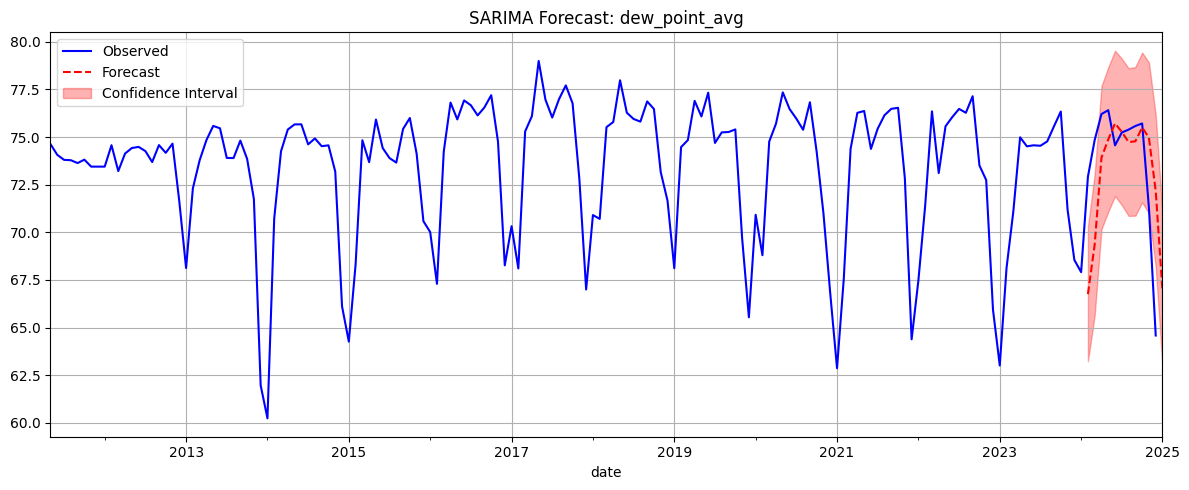

Forecasted values for dew_point_avg:
2024-02-01    66.754458
2024-03-01    69.357049
2024-04-01    73.917190
2024-05-01    74.872359
2024-06-01    75.715977
2024-07-01    75.271823
2024-08-01    74.733500
2024-09-01    74.776963
2024-10-01    75.504078
2024-11-01    74.956163
2024-12-01    72.166671
2025-01-01    66.929126
Freq: MS, Name: predicted_mean, dtype: float64
Forecast Accuracy Metrics for dew_point_avg:
MAE  : 1.131
RMSE : 1.447
MAPE : 1.57%
R²   : 0.833
Stationarity check for humidity_avg:
ADF Statistic: -1.650
p-value: 0.457
Critical Values:
   1%: -3.475
   5%: -2.881
   10%: -2.577
Stationary: No


C:\Users\poyni\AppData\Roaming\Python\Python312\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency ME will be used.
  self._init_dates(dates, freq)
C:\Users\poyni\AppData\Roaming\Python\Python312\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency ME will be used.
  self._init_dates(dates, freq)


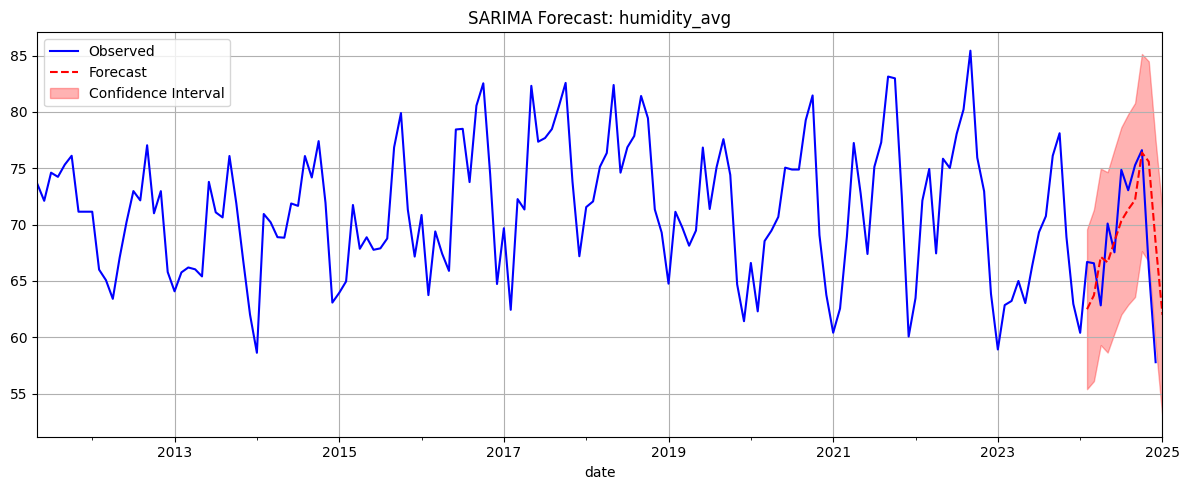

Forecasted values for humidity_avg:
2024-02-01    62.484817
2024-03-01    63.716142
2024-04-01    67.131172
2024-05-01    66.641146
2024-06-01    68.508541
2024-07-01    70.323820
2024-08-01    71.336566
2024-09-01    72.179952
2024-10-01    76.386326
2024-11-01    75.583529
2024-12-01    68.352143
2025-01-01    61.977386
Freq: MS, Name: predicted_mean, dtype: float64
Forecast Accuracy Metrics for humidity_avg:
MAE  : 2.227
RMSE : 2.519
MAPE : 3.38%
R²   : 0.809
Stationarity check for wind_speed_max:
ADF Statistic: -12.353
p-value: 0.000
Critical Values:
   1%: -3.472
   5%: -2.880
   10%: -2.577
Stationary: Yes


C:\Users\poyni\AppData\Roaming\Python\Python312\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency ME will be used.
  self._init_dates(dates, freq)
C:\Users\poyni\AppData\Roaming\Python\Python312\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency ME will be used.
  self._init_dates(dates, freq)


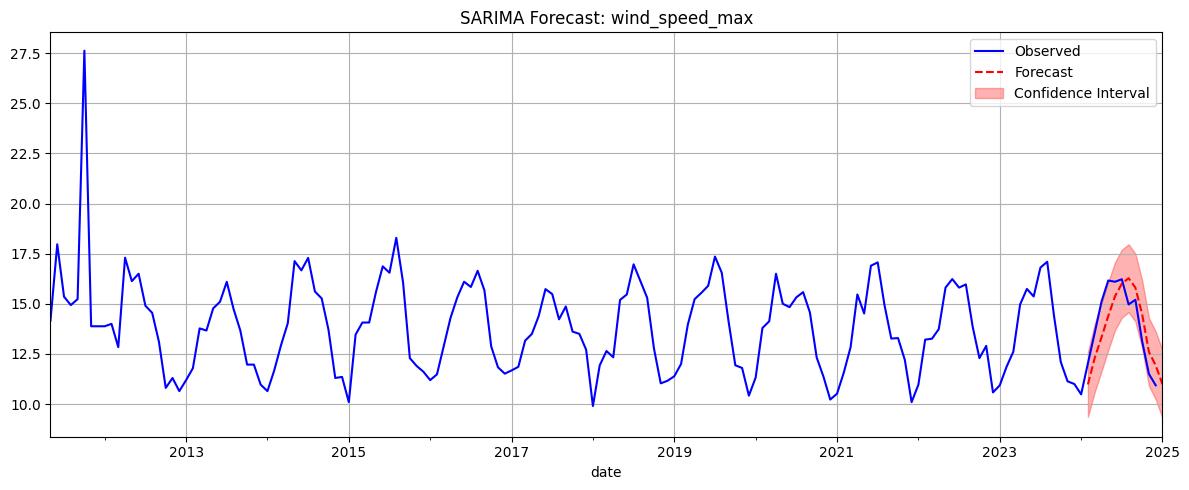

Forecasted values for wind_speed_max:
2024-02-01    10.978943
2024-03-01    12.295817
2024-04-01    13.322270
2024-05-01    14.389479
2024-06-01    15.379344
2024-07-01    16.001783
2024-08-01    16.276582
2024-09-01    15.806891
2024-10-01    14.477402
2024-11-01    12.596854
2024-12-01    11.924463
2025-01-01    10.982645
Freq: MS, Name: predicted_mean, dtype: float64
Forecast Accuracy Metrics for wind_speed_max:
MAE  : 0.432
RMSE : 0.515
MAPE : 3.13%
R²   : 0.936
Stationarity check for pressure_max:
ADF Statistic: -2.300
p-value: 0.172
Critical Values:
   1%: -3.474
   5%: -2.881
   10%: -2.577
Stationary: No


C:\Users\poyni\AppData\Roaming\Python\Python312\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency ME will be used.
  self._init_dates(dates, freq)
C:\Users\poyni\AppData\Roaming\Python\Python312\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency ME will be used.
  self._init_dates(dates, freq)


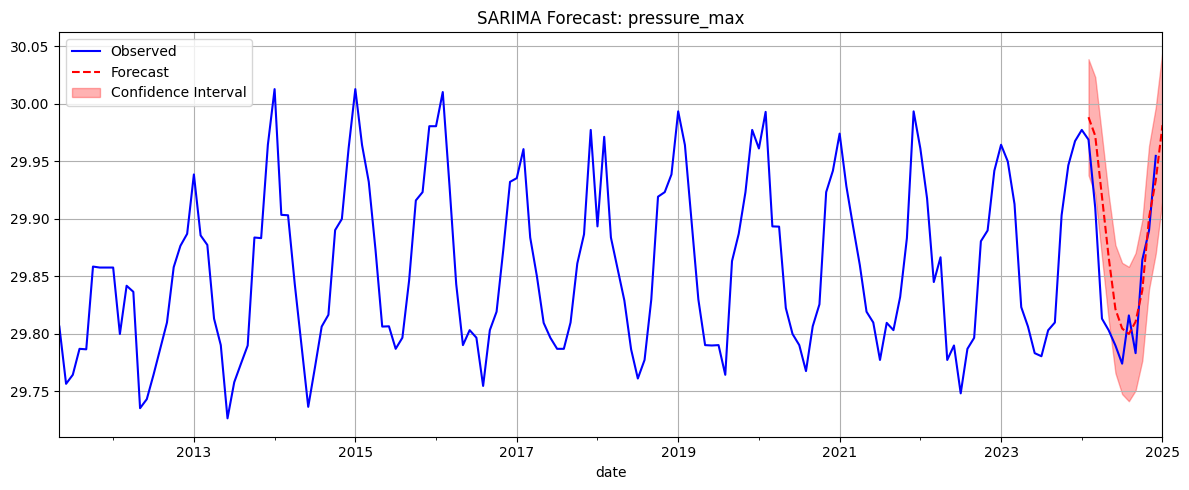

Forecasted values for pressure_max:
2024-02-01    29.988490
2024-03-01    29.972305
2024-04-01    29.919500
2024-05-01    29.866671
2024-06-01    29.821694
2024-07-01    29.804778
2024-08-01    29.799966
2024-09-01    29.810697
2024-10-01    29.837996
2024-11-01    29.901259
2024-12-01    29.933580
2025-01-01    29.981645
Freq: MS, Name: predicted_mean, dtype: float64
Forecast Accuracy Metrics for pressure_max:
MAE  : 0.025
RMSE : 0.031
MAPE : 0.08%
R²   : 0.822


In [37]:
SARIMA(0)

Stationarity check for temperature_min:
ADF Statistic: -2.850
p-value: 0.051
Critical Values:
   1%: -3.475
   5%: -2.881
   10%: -2.577
Stationary: No


C:\Users\poyni\AppData\Roaming\Python\Python312\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency ME will be used.
  self._init_dates(dates, freq)
C:\Users\poyni\AppData\Roaming\Python\Python312\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency ME will be used.
  self._init_dates(dates, freq)


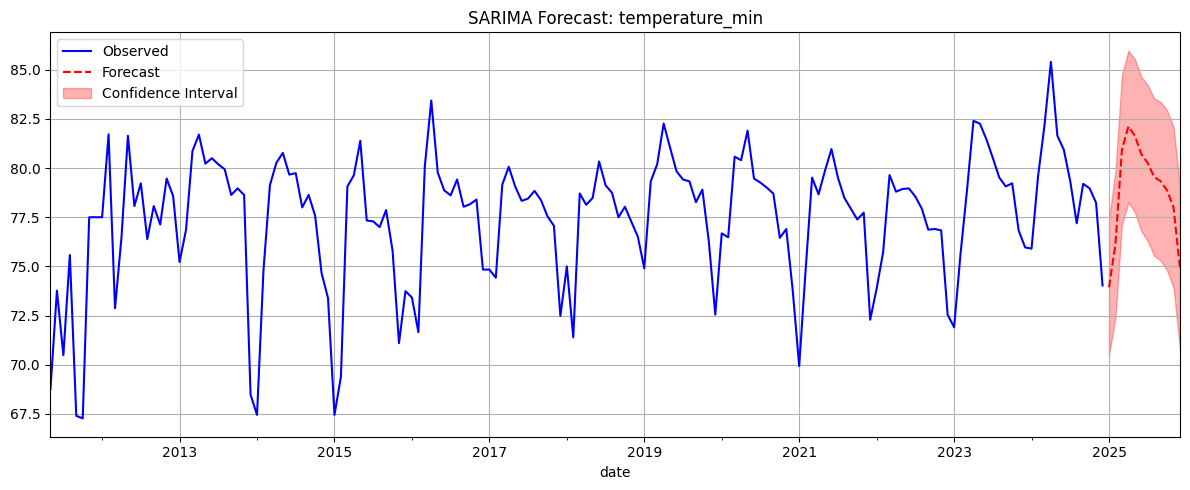

Forecasted values for temperature_min:
2025-01-01    73.937399
2025-02-01    76.130002
2025-03-01    80.932229
2025-04-01    82.110178
2025-05-01    81.649949
2025-06-01    80.714307
2025-07-01    80.251153
2025-08-01    79.541085
2025-09-01    79.332062
2025-10-01    78.862733
2025-11-01    77.997361
2025-12-01    74.879809
Freq: MS, Name: predicted_mean, dtype: float64
Stationarity check for dew_point_avg:
ADF Statistic: -2.161
p-value: 0.221
Critical Values:
   1%: -3.475
   5%: -2.881
   10%: -2.577
Stationary: No


C:\Users\poyni\AppData\Roaming\Python\Python312\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency ME will be used.
  self._init_dates(dates, freq)
C:\Users\poyni\AppData\Roaming\Python\Python312\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency ME will be used.
  self._init_dates(dates, freq)


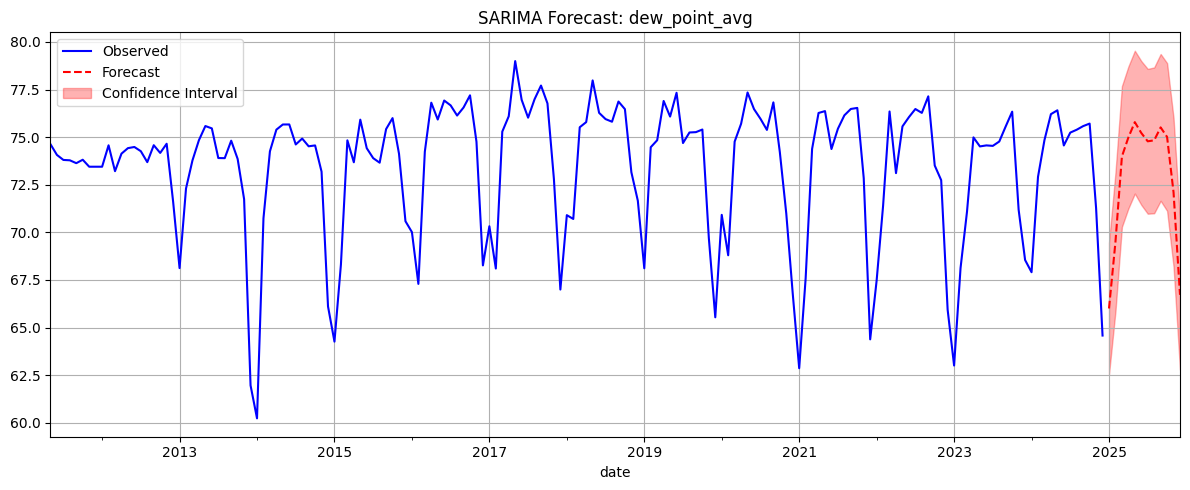

Forecasted values for dew_point_avg:
2025-01-01    66.001702
2025-02-01    69.495609
2025-03-01    73.983326
2025-04-01    74.981018
2025-05-01    75.788083
2025-06-01    75.220508
2025-07-01    74.781423
2025-08-01    74.832543
2025-09-01    75.512331
2025-10-01    75.009087
2025-11-01    72.101932
2025-12-01    66.717491
Freq: MS, Name: predicted_mean, dtype: float64
Stationarity check for humidity_avg:
ADF Statistic: -1.650
p-value: 0.457
Critical Values:
   1%: -3.475
   5%: -2.881
   10%: -2.577
Stationary: No


C:\Users\poyni\AppData\Roaming\Python\Python312\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency ME will be used.
  self._init_dates(dates, freq)
C:\Users\poyni\AppData\Roaming\Python\Python312\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency ME will be used.
  self._init_dates(dates, freq)


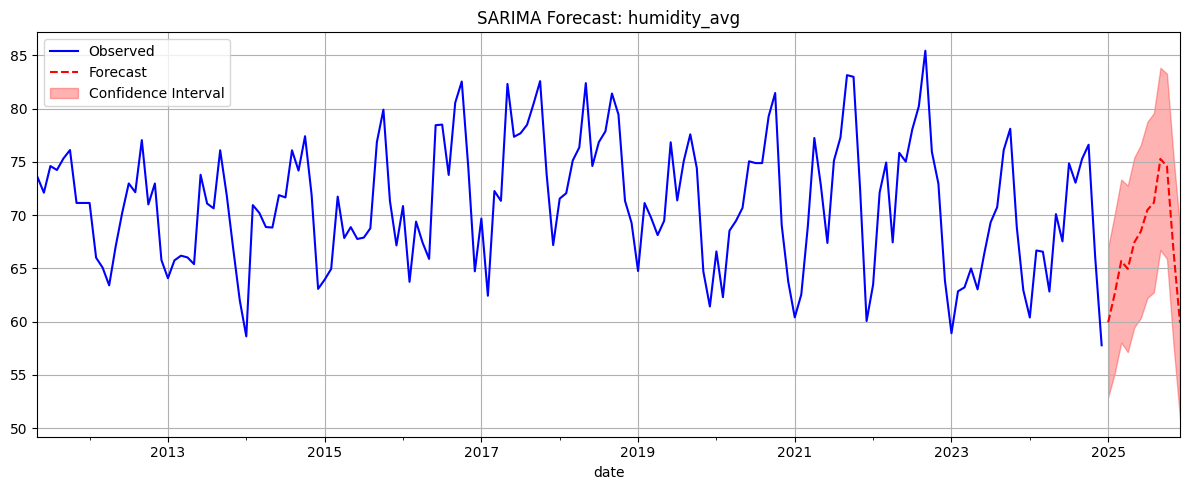

Forecasted values for humidity_avg:
2025-01-01    59.936968
2025-02-01    62.611846
2025-03-01    65.686083
2025-04-01    64.955275
2025-05-01    67.437158
2025-06-01    68.466501
2025-07-01    70.476092
2025-08-01    71.165397
2025-09-01    75.273864
2025-10-01    74.582823
2025-11-01    66.687027
2025-12-01    59.891367
Freq: MS, Name: predicted_mean, dtype: float64
Stationarity check for wind_speed_max:
ADF Statistic: -12.353
p-value: 0.000
Critical Values:
   1%: -3.472
   5%: -2.880
   10%: -2.577
Stationary: Yes


C:\Users\poyni\AppData\Roaming\Python\Python312\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency ME will be used.
  self._init_dates(dates, freq)
C:\Users\poyni\AppData\Roaming\Python\Python312\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency ME will be used.
  self._init_dates(dates, freq)


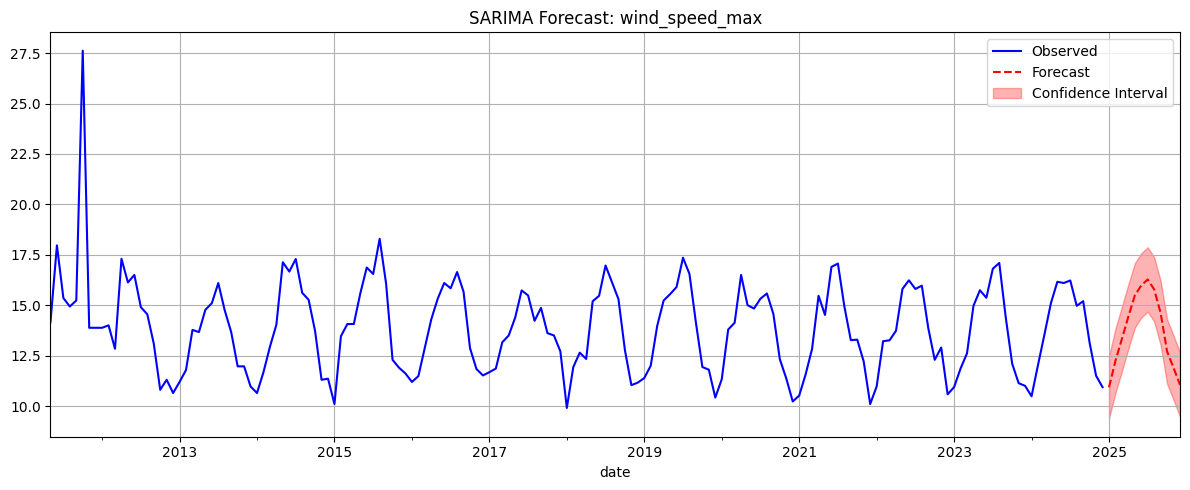

Forecasted values for wind_speed_max:
2025-01-01    10.927567
2025-02-01    12.243775
2025-03-01    13.327495
2025-04-01    14.436356
2025-05-01    15.481426
2025-06-01    15.980084
2025-07-01    16.277803
2025-08-01    15.780204
2025-09-01    14.610562
2025-10-01    12.701386
2025-11-01    11.896219
2025-12-01    11.054709
Freq: MS, Name: predicted_mean, dtype: float64
Stationarity check for pressure_max:
ADF Statistic: -2.300
p-value: 0.172
Critical Values:
   1%: -3.474
   5%: -2.881
   10%: -2.577
Stationary: No


C:\Users\poyni\AppData\Roaming\Python\Python312\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency ME will be used.
  self._init_dates(dates, freq)
C:\Users\poyni\AppData\Roaming\Python\Python312\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency ME will be used.
  self._init_dates(dates, freq)


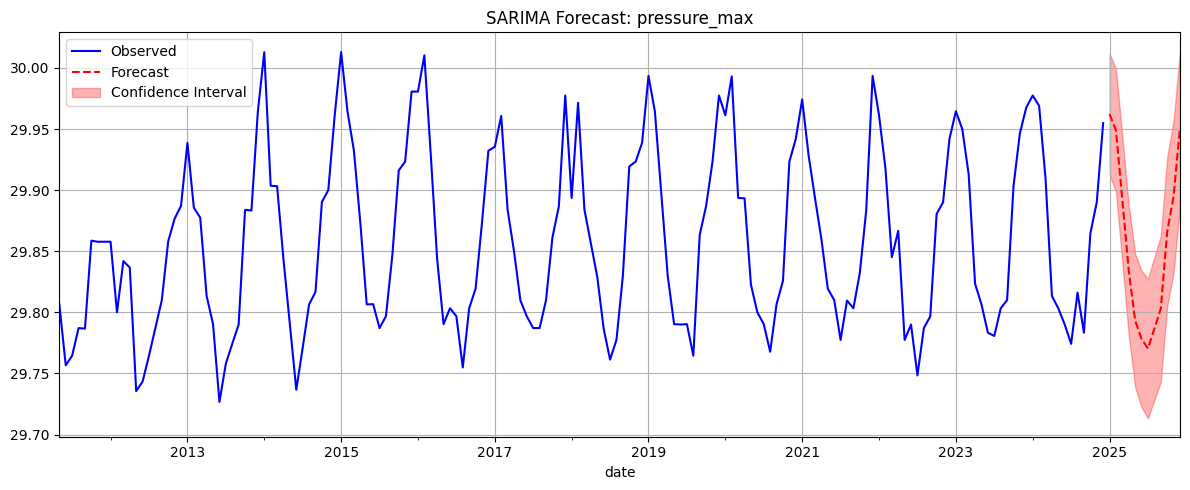

Forecasted values for pressure_max:
2025-01-01    29.962235
2025-02-01    29.948831
2025-03-01    29.891894
2025-04-01    29.833971
2025-05-01    29.793205
2025-06-01    29.778122
2025-07-01    29.770377
2025-08-01    29.786701
2025-09-01    29.802886
2025-10-01    29.865865
2025-11-01    29.894911
2025-12-01    29.951055
Freq: MS, Name: predicted_mean, dtype: float64


In [38]:
SARIMA(1)

In [39]:
forecast_combined_df

,temperature_min,dew_point_avg,humidity_avg,wind_speed_max,pressure_max
2025-01-01,73.937399,66.001702,59.936968,10.927567,29.962235
2025-02-01,76.130002,69.495609,62.611846,12.243775,29.948831
2025-03-01,80.932229,73.983326,65.686083,13.327495,29.891894
2025-04-01,82.110178,74.981018,64.955275,14.436356,29.833971
2025-05-01,81.649949,75.788083,67.437158,15.481426,29.793205
2025-06-01,80.714307,75.220508,68.466501,15.980084,29.778122
2025-07-01,80.251153,74.781423,70.476092,16.277803,29.770377
2025-08-01,79.541085,74.832543,71.165397,15.780204,29.786701
2025-09-01,79.332062,75.512331,75.273864,14.610562,29.802886
2025-10-01,78.862733,75.009087,74.582823,12.701386,29.865865


In [40]:
forecast_combined_df.to_csv("../../data/a1/bkk_weather_forecasts.csv", index=True)

Actually, it could be tuned p q more by watching, but i think accuracy is enough with general paramerters. so ACF and PACF I just plot just in case.

**For p (AR order):**

- Count how many significant spikes there are in the PACF before it cuts off (drops to near zero). This number would be your p value

**For q (MA order):**

- Count how many significant spikes there are in the ACF before it cuts off. This number would be your q value